# Polynomial Regression Model 

## Model Overview

This project implements a **Polynomial Regression model (Degree = 2)** to predict house sale prices using the Ames Housing dataset.  
The model uses the same preprocessing pipeline as Linear Regression but expands all numeric and encoded features into polynomial terms to capture **non-linear relationships**.

Polynomial Regression was applied after transforming the data into a 286-feature matrix produced by one-hot encoding and scaling. The polynomial expansion increases feature interactions, allowing the model to fit more complex patterns.

---

## Data Preparation

The dataset contains **1,460 records and 81 columns**. It was split into:
- **80% training data (1,168 samples)**
- **20% validation data (292 samples)**  
using `train_test_split` with `random_state=42`.

**Feature Identification:**
- **Numeric Features:** 37  
  - Processed using median imputation + StandardScaler  
- **Categorical Features:** 43  
  - Processed using most frequent imputation + OneHotEncoder  

The preprocessed dataset resulted in **286 engineered features**.

---

## Preprocessing Pipeline

The same preprocessing pipeline used in the Linear Regression model was applied:

1. **Numeric Transformer**
   - Median imputation for missing values  
   - StandardScaler normalization  

2. **Categorical Transformer**
   - Most frequent imputation  
   - OneHotEncoder with `handle_unknown="ignore"`  

3. **ColumnTransformer**
   - Combines numeric and categorical transformations  
   - Produces a sparse matrix of 286 total features  

---

## Polynomial Feature Expansion

To model non-linear relationships, a **PolynomialFeatures transformer** was added:

- Degree = **2**
- Bias term = excluded (`include_bias=False`)
- Captures interactions between original features  
- Significantly increases feature dimensionality  

This step enables the model to learn curved and complex patterns that standard Linear Regression cannot capture.

---

## Model Training

After polynomial feature expansion:

- A **Linear Regression model** was trained on the transformed training set  
- Polynomial Regression internally remains a linear model but operates on polynomial features, improving flexibility and accuracy when relationships are nonlinear  

---

## Model Evaluation

The MLP model was evaluated using **regression metrics**:

### Regression Metrics:
- **Mean Squared Error (MSE)**  
- **Mean Absolute Error (MAE)**  
- **R² Score**
- **RMSE (Root Mean Squared Error)**

These metrics quantify the prediction accuracy and error magnitude.

---

## Classification-Based Evaluation

To provide additional interpretability, SalePrice values were grouped into three price categories:

- **Low**
- **Mid**
- **High**

Both predicted and actual prices were binned to evaluate how well the model distinguishes between price groups.

### Metrics computed:
- **Precision**
- **Recall**
- **F1-Score**
- **Confusion Matrix**

This allows us to interpret how well the model categorizes homes across price ranges, even though the task remains fundamentally a regression problem.

---


## Visual Analysis

The following diagnostic plots were generated:

- **Actual vs Predicted Plot**
Shows how close the predicted prices are to the true prices.  
Patterns reveal that polynomial regression captures more curvature than simple linear models but may slightly overfit.

- **Residual Plot**
Plots prediction errors vs predicted values.  
Residual patterns help visualize:
- Non-linearity  
- Variance in error across price ranges  
Polynomial regression reduces some systematic bias but increases variance at higher price levels.

- **Error Distribution Histogram**
Displays the spread of residuals.  
A roughly centered distribution indicates unbiased predictions, though polynomial models may produce wider tails due to model flexibility.

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [15]:
train_path = 'data/train.csv'
train_df = pd.read_csv(train_path)
print("Train shape:", train_df.shape)
train_df.head()

Train shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
target = 'SalePrice'
drop_cols = [target]
if target+'_log' in train_df.columns:
    drop_cols.append(target+'_log')

X = train_df.drop(columns=drop_cols)
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Training shape: (1168, 80)
Validation shape: (292, 80)


In [18]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

Numeric features: 37
Categorical features: 43


In [19]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
print("Preprocessing done.")

Preprocessing done.


In [20]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_processed)
X_val_poly = poly.transform(X_val_processed)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred = model.predict(X_val_poly)

In [21]:
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Polynomial Regression Metrics:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Polynomial Regression Metrics:
MSE: 1023436528.0012721
RMSE: 31991.194538517502
MAE: 21595.39521110127
R²: 0.8665719683418016


In [22]:
y_val_cat = pd.qcut(y_val, q=3, labels=["Low", "Mid", "High"])
y_pred_cat = pd.qcut(y_pred, q=3, labels=["Low", "Mid", "High"])

Classification Report (Price Categories):
              precision    recall  f1-score   support

        High       0.85      0.85      0.85        98
         Low       0.80      0.80      0.80        98
         Mid       0.66      0.67      0.66        96

    accuracy                           0.77       292
   macro avg       0.77      0.77      0.77       292
weighted avg       0.77      0.77      0.77       292



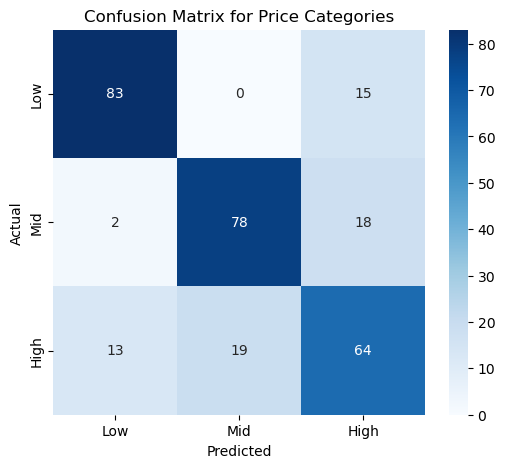

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report (Price Categories):")
print(classification_report(y_val_cat, y_pred_cat))

cm = confusion_matrix(y_val_cat, y_pred_cat)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low","Mid","High"], yticklabels=["Low","Mid","High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Price Categories")
plt.show()

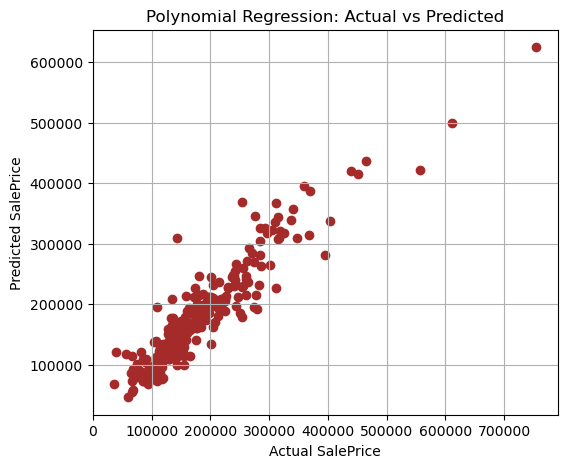

In [24]:
plt.figure(figsize=(6,5))
plt.scatter(y_val, y_pred, color='brown')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Polynomial Regression: Actual vs Predicted")
plt.grid(True)
plt.show()

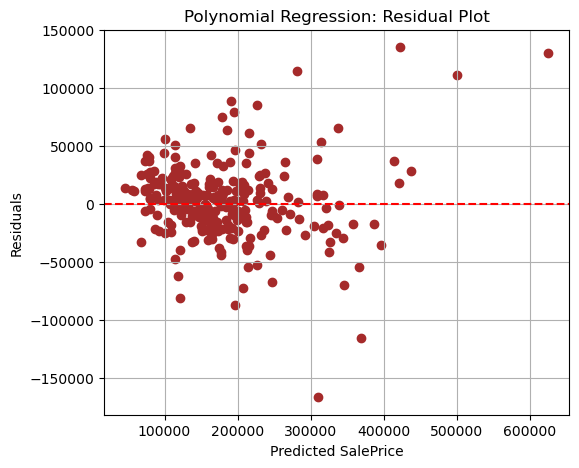

In [25]:
residuals = y_val - y_pred
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, color='brown')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Polynomial Regression: Residual Plot")
plt.grid(True)
plt.show()

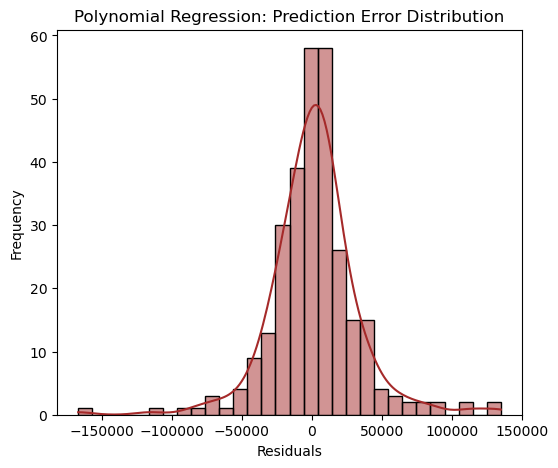

In [26]:
plt.figure(figsize=(6,5))
sns.histplot(residuals, bins=30, kde=True, color='brown')
plt.title("Polynomial Regression: Prediction Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()